<a href="https://colab.research.google.com/github/kaveku/DeepLearning/blob/main/logistic_regression_in_a_single_layered_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
import torchvision
from torch import Tensor
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [ ]:
torch.cuda.is_available()

True

In [ ]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

In [ ]:
#Loading the MNIST Dataset
train_dataloader = DataLoader(
    dataset=MNIST(
        root="/tmp/mnist",
        train=True,
        transform=ToTensor(),
        download=True,
    ),
    batch_size=64,
    shuffle=True,
)

test_dataloader = DataLoader(
    dataset=MNIST(
        root="/tmp/mnist",
        train=False,
        transform=ToTensor(),
        download=True,
    ),
    batch_size=64,
    shuffle=False,
)

(-0.5, 27.5, 27.5, -0.5)

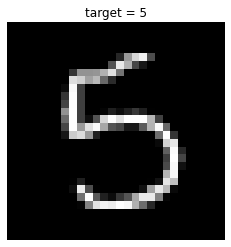

In [ ]:
image, target = [*test_dataloader][0]

random_index = np.random.randint(0, 64)

image, target = image[random_index, 0], target[random_index]

plt.imshow(
    image, 
    cmap="gray", 
    interpolation="nearest",
)

plt.title(f"target = {target}")
plt.axis("off")

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size: int, num_classes: int):
        super(LogisticRegression, self).__init__()

        #Instantiating the layer
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x: Tensor) -> Tensor:

        #Defining forward_pass
        y_pred = self.linear(x)
        return y_pred
        #return torch.sigm(y_pred)



In [ ]:
module = LogisticRegression(28 * 28, 10)
module= module.to(device)
optimizer = torch.optim.SGD(module.parameters(), lr = 0.01)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
# Training the Model

EPOCHS = 5

# Exponential moving average of the loss:
ema = None
module.train()
for epoch in range(EPOCHS):
  for batch_index, (train_images, train_targets) in enumerate(train_dataloader):
      train_images = train_images.view(-1, 28 * 28).requires_grad_().to(device)
      #print(train_images.shape, train_targets.shape)

      train_targets = train_targets.to(device)

      # Clear gradients w.r.t. parameters
      optimizer.zero_grad()

      # Forward pass to get output/logits
      outputs = module(train_images)

      # Calculate Loss: softmax --> cross entropy loss
      loss = criterion(outputs, train_targets)

      # Getting gradients w.r.t. parameters
      loss.backward()

      # Updates parameters:
      optimizer.step()

      # NOTE: It is important to call .item() on the loss before summing.
      if ema is None:
          ema = loss.item()
      else:
          ema += (loss.item() - ema) * 0.01

      if batch_index % 500 == 0:
          print(
              "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                  epoch,
                  batch_index * len(train_images),
                  len(train_dataloader.dataset),
                  100.0 * batch_index / len(train_dataloader),
                  ema,
              ),
          )

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.305103
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.914016
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.658149
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.547165
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.513985
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.469778
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.448517
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.433705
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.423047
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.403034


In [ ]:
#Visualizing the weights
assert module.linear.weight.shape == (10, 28 * 28)

(-0.5, 151.5, 61.5, -0.5)

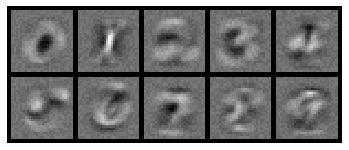

In [ ]:
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            module.linear.weight.view(10, 1, 28, 28).to('cpu'),
            normalize=True,
            nrow=5,
        ), 
        (1, 2, 0),
    ), 
    interpolation="nearest",
)

plt.grid(False)
plt.gca().axis("off")

In [ ]:
correct_predictions = 0
predictions = 0

# Iterate through test dataset
with torch.no_grad():
  for test_images, test_targets in test_dataloader:
      test_images = test_images.view(-1, 28 * 28).to(device)

      # Forward pass only to get logits/output
      outputs = module(test_images)

      # Get predictions from the maximum value
      _, predicted = torch.max(outputs.data, 1)

      predictions += test_targets.size(0)

      if torch.cuda.is_available():
          correct_predictions += (predicted.cpu() == test_targets.cpu()).sum()
      else:
          correct_predictions += (predicted == test_targets).sum()

correct_predictions.item() / predictions

0.8989

In [ ]:
#X = (28, 28, 3)